# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

# OList profit analysis

## Setup

### Imports

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from olist.order import Order
from olist.seller import Seller
from olist.data import Olist

### Instantiate classes

In [115]:
olist = Olist()
seller = Seller()

### Load data

In [116]:
data = olist.get_data()

In [117]:
sellers = seller.get_training_data()
sellers.info()
sellers.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2967 entries, 0 to 2966
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   seller_id           2967 non-null   object        
 1   seller_city         2967 non-null   object        
 2   seller_state        2967 non-null   object        
 3   delay_to_carrier    2967 non-null   float64       
 4   wait_time           2967 non-null   float64       
 5   date_first_sale     2967 non-null   datetime64[ns]
 6   date_last_sale      2967 non-null   datetime64[ns]
 7   months_on_olist     2967 non-null   float64       
 8   n_orders            2967 non-null   int64         
 9   quantity            2967 non-null   int64         
 10  quantity_per_order  2967 non-null   float64       
 11  sales               2967 non-null   float64       
 12  review_score        2967 non-null   float64       
 13  review_cost         2967 non-null   float64     

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,review_cost,dim_is_one_star,dim_is_five_star
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.0,218.7,3.0,140.0,0.000323,0.000323


### Functions

#### Calculate IT costs
$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
- $\alpha = 3157.27$
- $\beta = 978.23$

In [118]:
def calculate_it_cost(quantity_products, n_sellers):
    alpha = 3157.27
    beta = 978.23
    it_costs = alpha * np.sqrt(n_sellers) + beta * np.sqrt(quantity_products)
    return it_costs

#### Calculate total profit for subset of sellers/product

In [119]:
#Calculate the total profit dependent on the number of sellers
def calculate_total_profit(data: pd.DataFrame):
    it_cost = calculate_it_cost(
    data["quantity"].sum(), data.shape[0]
)
    total_profit = data["profit_or_loss"].sum() - it_cost

    return total_profit


## Data preparation

### Revenue per seller (sales + subscription)

In [120]:
sellers_enhanced = sellers.copy()
sellers_enhanced["sales_revenue"] = sellers_enhanced["sales"] * 0.1
sellers_enhanced["subscription_revenue"] = sellers_enhanced["months_on_olist"] * 80
sellers_enhanced.head(1)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,review_cost,dim_is_one_star,dim_is_five_star,sales_revenue,subscription_revenue
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.0,218.7,3.0,140.0,0.000323,0.000323,21.87,320.0


### Profit/loss per seller

In [121]:
seller_cost_and_revenue = sellers_enhanced.copy()
seller_cost_and_revenue["profit_or_loss"] = (
    seller_cost_and_revenue["sales_revenue"]
    + seller_cost_and_revenue["subscription_revenue"]
    - seller_cost_and_revenue["review_cost"]
)
print("Number of rows/columns:", seller_cost_and_revenue.shape)
seller_cost_and_revenue.head(1)

Number of rows/columns: (2967, 19)


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,review_cost,dim_is_one_star,dim_is_five_star,sales_revenue,subscription_revenue,profit_or_loss
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.0,218.7,3.0,140.0,0.000323,0.000323,21.87,320.0,201.87


## Analysis

### Distribution of profit per seller

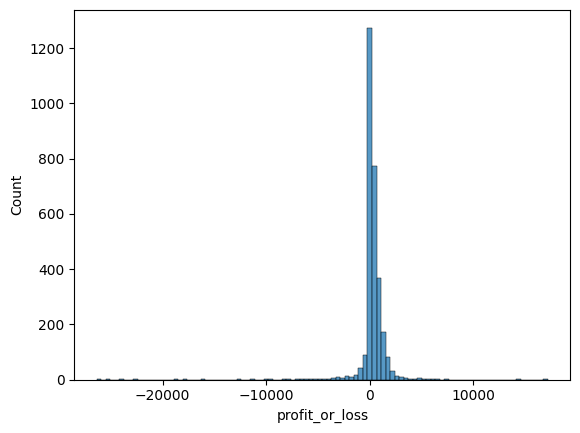

In [127]:
sns.histplot(x="profit_or_loss", data=seller_cost_and_revenue, bins=100);

In [142]:
s = seller_cost_and_revenue.sort_values("profit_or_loss", ascending=True)[:100]
t = seller_cost_and_revenue.sort_values("profit_or_loss", ascending=True)[100:]

print(s["review_score"].mean())
print(t["review_score"].mean())

s.head(20)

3.718541543884169
4.085330203232367


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,review_cost,dim_is_one_star,dim_is_five_star,sales_revenue,subscription_revenue,profit_or_loss
769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.000000,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1854,2033,1.096548,123304.83,3.906653,40120.0,0.086268,0.329887,12330.483,1440.0,-26349.517
453,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,0.000000,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,17.0,1404,1931,1.375356,106939.21,3.985959,37190.0,0.090792,0.353150,10693.921,1360.0,-25136.079
1132,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,0.000000,22.392546,2017-01-26 22:55:10,2018-08-08 03:10:34,18.0,982,1364,1.389002,187923.89,3.337758,44250.0,0.104362,0.140549,18792.389,1440.0,-24017.611
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.000000,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,1.100221,200472.92,3.796636,44400.0,0.094669,0.304362,20047.292,1600.0,-22752.708
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.000000,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,1.040445,104288.42,4.056593,30840.0,0.069144,0.333118,10428.842,1520.0,-18891.158
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.000000,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,1.049738,37177.52,3.952341,22560.0,0.048142,0.200000,3717.752,960.0,-17882.248
2603,1025f0e2d44d7041d6cf58b6550e0bfa,sao paulo,SP,0.000000,12.051349,2017-07-09 11:30:17,2018-08-26 09:35:15,14.0,915,1428,1.560656,138968.55,3.840395,31190.0,0.075606,0.233926,13896.855,1120.0,-16173.145
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.000000,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,1.079533,17535.69,3.995069,18460.0,0.042649,0.178998,1753.569,800.0,-15906.431
1213,d2374cbcbb3ca4ab1086534108cc3ab7,ibitinga,SP,0.000000,14.297115,2017-02-10 15:50:20,2018-08-22 04:04:20,18.0,524,631,1.204198,21223.92,3.661316,16400.0,0.035864,0.092084,2122.392,1440.0,-12837.608
2687,1835b56ce799e6a4dc4eddc053f04066,ibitinga,SP,0.000000,12.770314,2017-09-05 23:15:10,2018-08-25 16:50:21,12.0,423,558,1.319149,33344.21,3.588768,15720.0,0.039095,0.078837,3334.421,960.0,-11425.579


### Quantity of products per sellers ordered best-worst

<AxesSubplot:ylabel='quantity'>

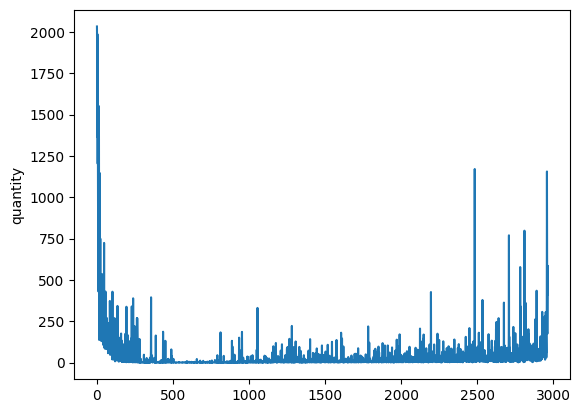

In [136]:
n_sellers = seller_cost_and_revenue.shape[0]
seller_cost_and_revenue.columns

sns.lineplot(x=range(0,n_sellers), y=seller_cost_and_revenue.sort_values("profit_or_loss", ascending=True)["quantity"])

<AxesSubplot:ylabel='dim_is_one_star'>

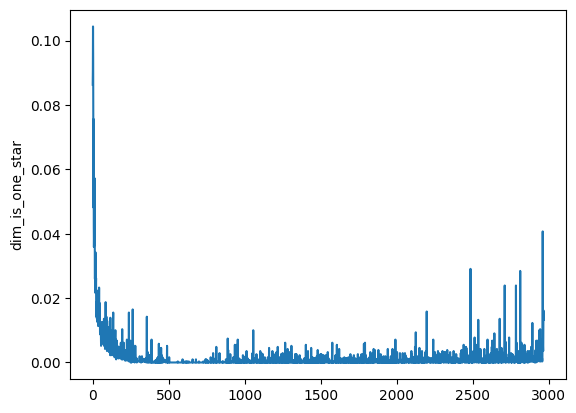

In [152]:
n_sellers = seller_cost_and_revenue.shape[0]
sns.lineplot(x=range(0,n_sellers), y=seller_cost_and_revenue.sort_values("profit_or_loss", ascending=True)["dim_is_one_star"])

### Total Olist profit

In [123]:
print("Olist's total profit with the currents sellers is", calculate_total_profit(
        seller_cost_and_revenue))

Olist's total profit with the currents sellers is 316439.1254806706


### Change in Olist profit if we remove the lowest-performing sellers

In [124]:
n_sellers = seller_cost_and_revenue.shape[0]
profits = []
for x in range(0, n_sellers):
    df_filtered = seller_cost_and_revenue.sort_values("profit_or_loss", ascending=True)[x:]
    profits.append(calculate_total_profit(df_filtered))


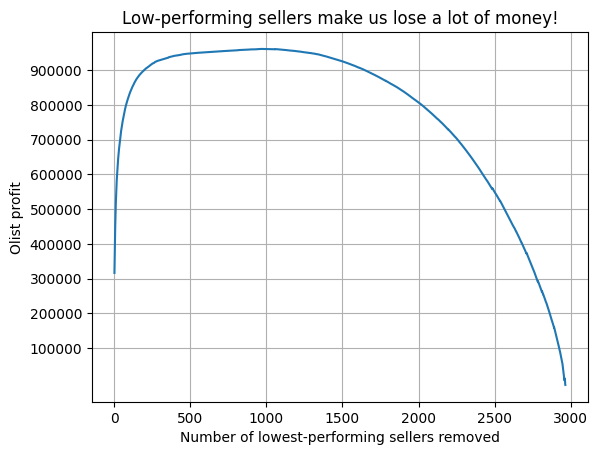

In [125]:
sns.lineplot(x=range(0,n_sellers), y=profits)
plt.grid()
plt.title("Low-performing sellers make us lose a lot of money!")
plt.ylabel("Olist profit")
plt.xlabel("Number of lowest-performing sellers removed")
plt.gca().set_yticks(np.linspace(1e5, 9e5, 9));

### Proposal

In [138]:
lower_limtit = 200
higher_limit = profits.index(max(profits))
print(f"Remove the {lower_limtit} worst performing sellers to get a total profit of {profits[lower_limtit]}")
print(f"Remove the {higher_limit} worst performing sellers to maximize total profit of {profits[higher_limit]}")

Remove the 200 worst performing sellers to get a total profit of 901651.8844516469
Remove the 963 worst performing sellers to maximize total profit of 960835.6028675792
